# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [19]:
import pandas as pd

path = 'D:\\Data\\df_STA_2020_12_01.csv'
df_sta = pd.read_csv(path)
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
0,S01,D04,Left,100.0,0,0.065894
1,S01,D04,Left,100.0,1,0.109876
2,S01,D04,Left,100.0,2,0.131164
3,S01,D04,Left,100.0,3,0.101857
4,S01,D04,Left,100.0,4,0.125714


In [20]:
df_sta.dtypes

Animal             object
Day                object
Side               object
Stim_Amplitude    float64
Sample              int64
STA_Amplitude     float64
dtype: object

#### For this analysis, we will only keep the right side EMG for SPARC and left side EMG for Neilsen (for now)

In [21]:
if 'NEIL' in path: 
    df_sta = df_sta[df_sta["Side"] == 'Left']
else:
    df_sta = df_sta[df_sta["Side"] == 'Right']

In [22]:
# this corrects a typo in a file name... 
df_sta.loc[df_sta.Day == 'D13', 'Day'] = 'D14'

In [23]:
print(df_sta.Animal.unique())
print(df_sta.Day.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['S01' 'S02' 'S03' 'S04' 'S05' 'S06']
['D04' 'D06' 'D08' 'D10' 'D12' 'D14' 'D16' 'D18']
['Right']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


#### We will also change the 'Day' column to have integer values.

In [6]:
df_sta['Day'] = df_sta['Day'].str[-2:].astype(int)
df_sta.head(), df_sta.dtypes, 

(  Animal  Day  Side  Stim_Amplitude  Sample  STA_Amplitude
 0    S01    4  Left           100.0       0       0.065894
 1    S01    4  Left           100.0       1       0.109876
 2    S01    4  Left           100.0       2       0.131164
 3    S01    4  Left           100.0       3       0.101857
 4    S01    4  Left           100.0       4       0.125714,
 Animal             object
 Day                 int32
 Side               object
 Stim_Amplitude    float64
 Sample              int64
 STA_Amplitude     float64
 dtype: object)

### Plot stimulus triggered average waveforms
##### For each current amplitude, each animal, and each day
There is a lot of data here, so we will subset. Only plot waveforms of stimulation amplitudes divisible by 50 on odd numbered days. We also need to remove the stimulus artifact.

In [7]:
df_sta_50 = df_sta[(df_sta["Stim_Amplitude"] % 50) == 0] # keep only stimulus amplitudes divisible by 50
"Unique stimulation amplitudes after subsetting are %s uA." % (df_sta_50.Stim_Amplitude.unique())

'Unique stimulation amplitudes after subsetting are [100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600.] uA.'

###### The plot below is the raw STA data before any processing

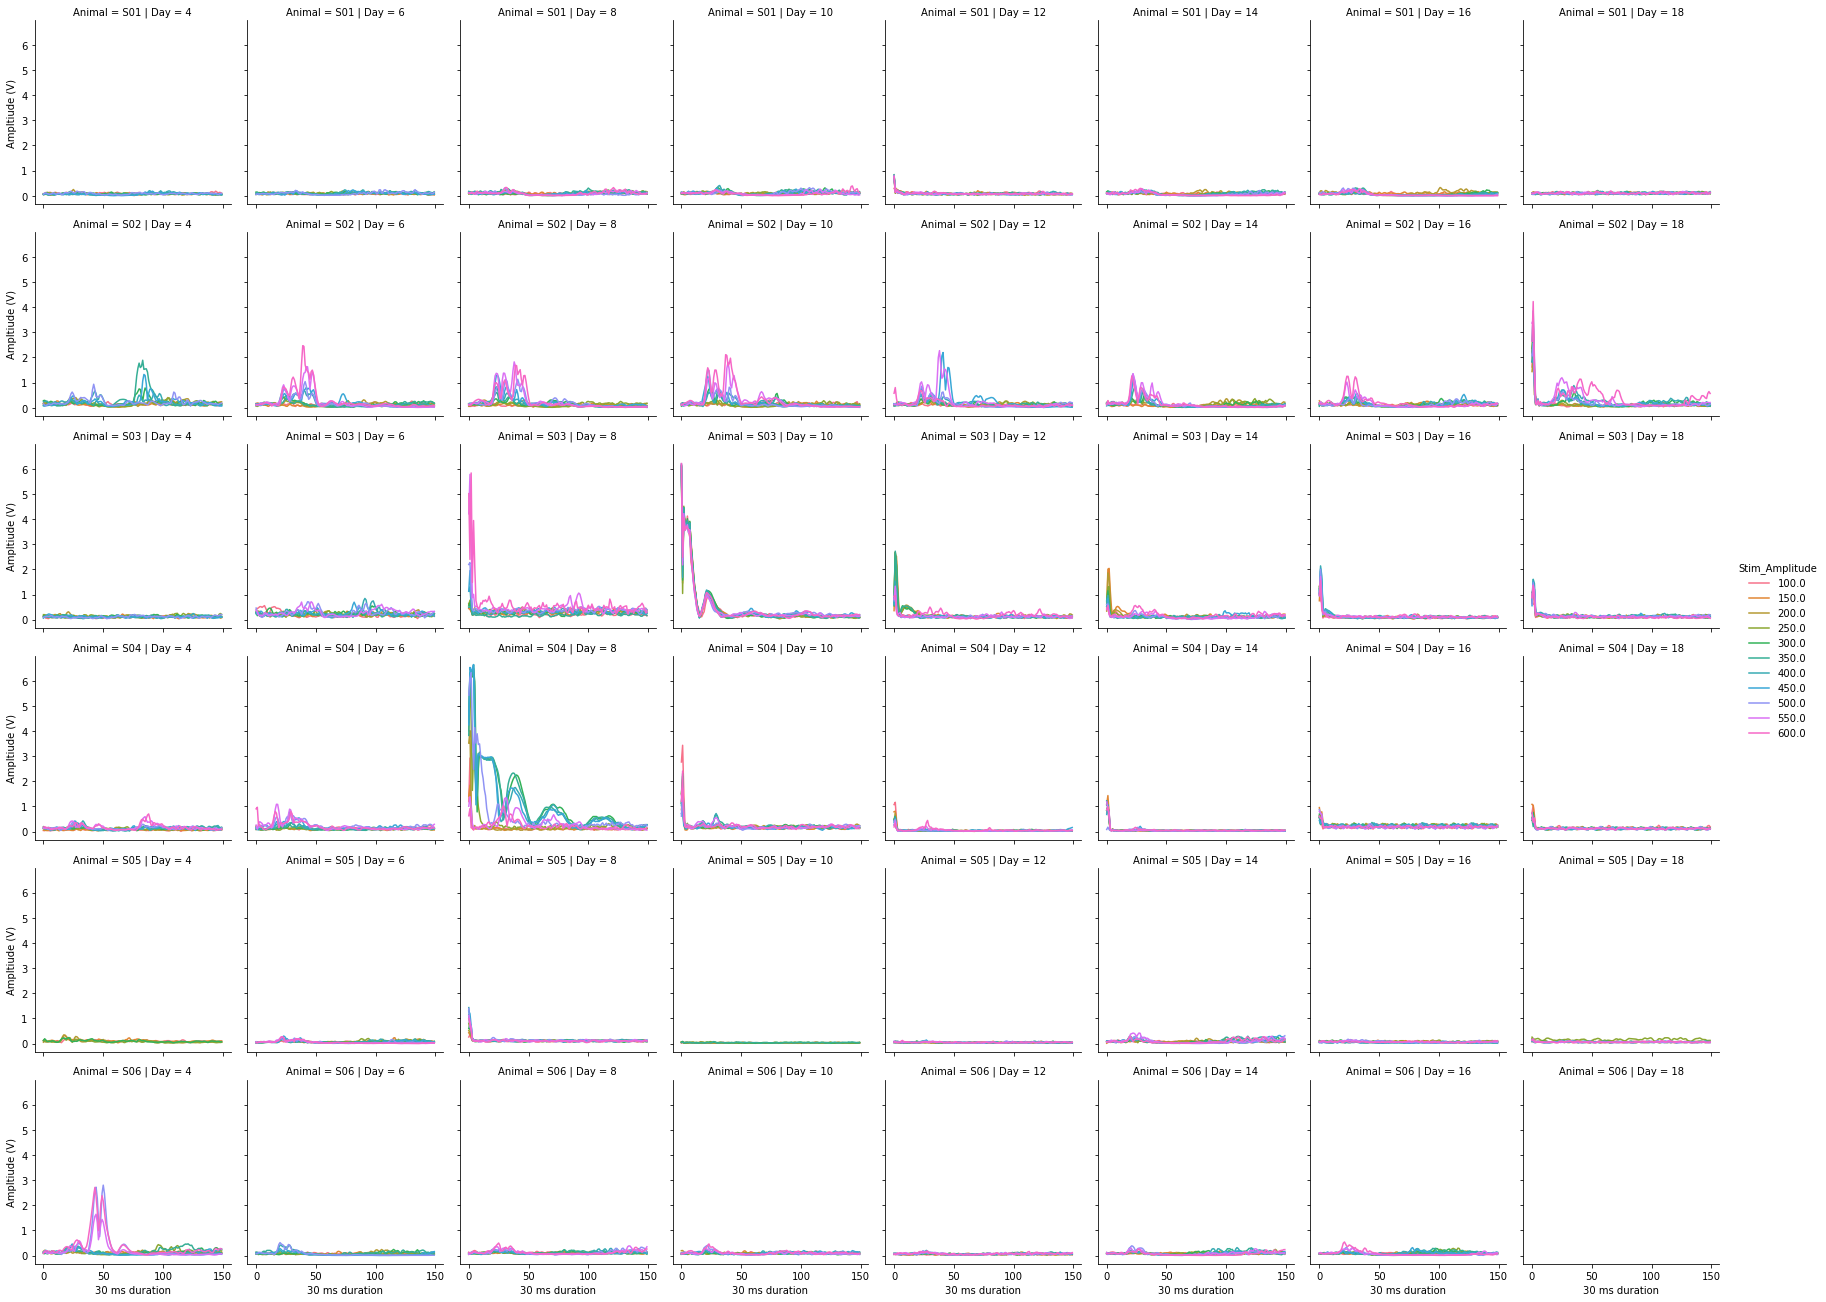

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df_sta_50, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Amplitude')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

###### These traces need to be normalized so they can be compared. This step should be given a lot of thought as normalization schemes can dramatically influence your model. The stimulus artifact must also be removed so it does not affect the normalization.

As a first pass, we will use a min/max scaler. Take all days for each animal and rescale the STAs such that all values are between 0 and 1

In [9]:
# remove the stimulus artifact by deleting samples 0 to 9
df_sta = df_sta[df_sta['Sample'] >= 10]
df_sta_50 = df_sta_50[df_sta_50['Sample'] >= 10]

# scale STA values to be within the range [0,1]
from sklearn.preprocessing import minmax_scale

STA_Scaled = df_sta.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
df_sta_norm = df_sta.copy()
df_sta_norm['STA_Scaled'] = df_sta_norm.index.map(STA_Scaled)
df_sta_norm = df_sta_norm.drop(['STA_Amplitude'], axis=1).reset_index(drop=True)

STA_Scaled_50 = df_sta_50.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
df_sta_50_norm = df_sta_50.copy()
df_sta_50_norm['STA_Scaled'] = df_sta_50_norm.index.map(STA_Scaled_50)
df_sta_50_norm = df_sta_50_norm.drop(['STA_Amplitude'], axis=1).reset_index(drop=True)

###### The plot below shows the normalized STAs with stimulus artifact removed

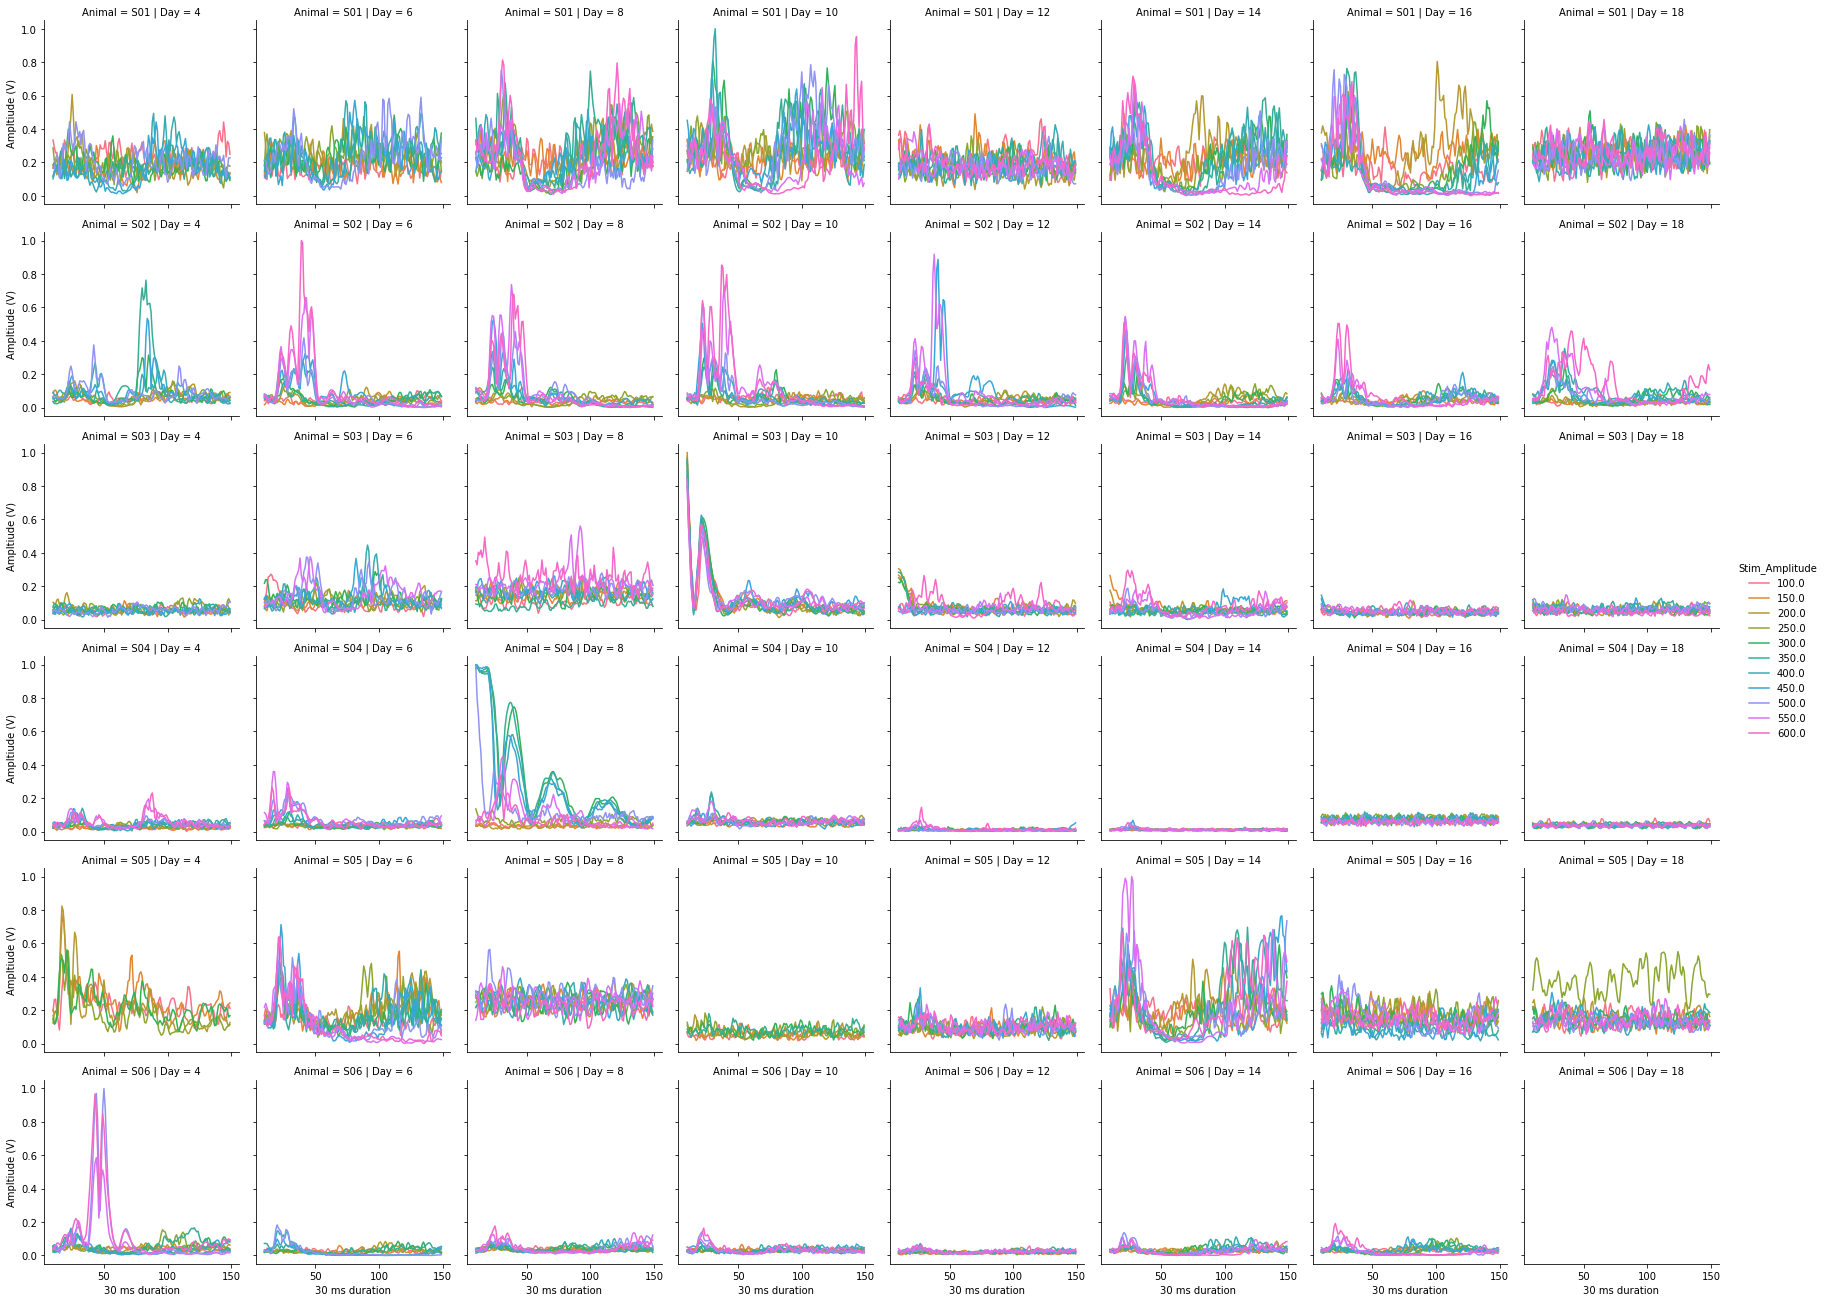

In [10]:
g = sns.FacetGrid(df_sta_50_norm, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Scaled')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [11]:
df_sta_50_norm.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Scaled
0,S01,4,Left,100.0,10,0.333202
1,S01,4,Left,100.0,11,0.290416
2,S01,4,Left,100.0,12,0.255910
3,S01,4,Left,100.0,13,0.259737
4,S01,4,Left,100.0,14,0.190045


The dataframe looks as expected. We now want to add a column that defines sample bins of interest so we can compare metrics at different latencies (e.g., how does the area under the curve differ in the bins 0 to 5 ms vs. 5 to 10 ms?). We will first convert 'Sample' to 'Time' and then define bins of interest.

In [12]:
sampling_frequency = 5000 # hertz
df_sta_50_norm['Time'] = df_sta_50_norm['Sample']/sampling_frequency # create time column based on samples and sampling frequency

In [13]:
bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
#labels = [1, 2, 3, 4, 5]

df_bin = df_sta_50_norm.copy()
df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'Time_Bin', 'STA_Scaled'])
df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
df_bin.head()

,Animal,Day,Side,Stim_Amplitude,Sample,Time,Bin,STA_Scaled
0,S01,4,Left,100.0,10,0.0020,1 to 4 ms,0.333202
1,S01,4,Left,100.0,11,0.0022,1 to 4 ms,0.290416
2,S01,4,Left,100.0,12,0.0024,1 to 4 ms,0.255910
3,S01,4,Left,100.0,13,0.0026,1 to 4 ms,0.259737
4,S01,4,Left,100.0,14,0.0028,1 to 4 ms,0.190045


###### Below is a plot showing the data we will be working with. Data are normalized and are cut off at 13 ms after the stimulus. Also, only stimulation amplitudes divisible by 50 are in this dataframe.

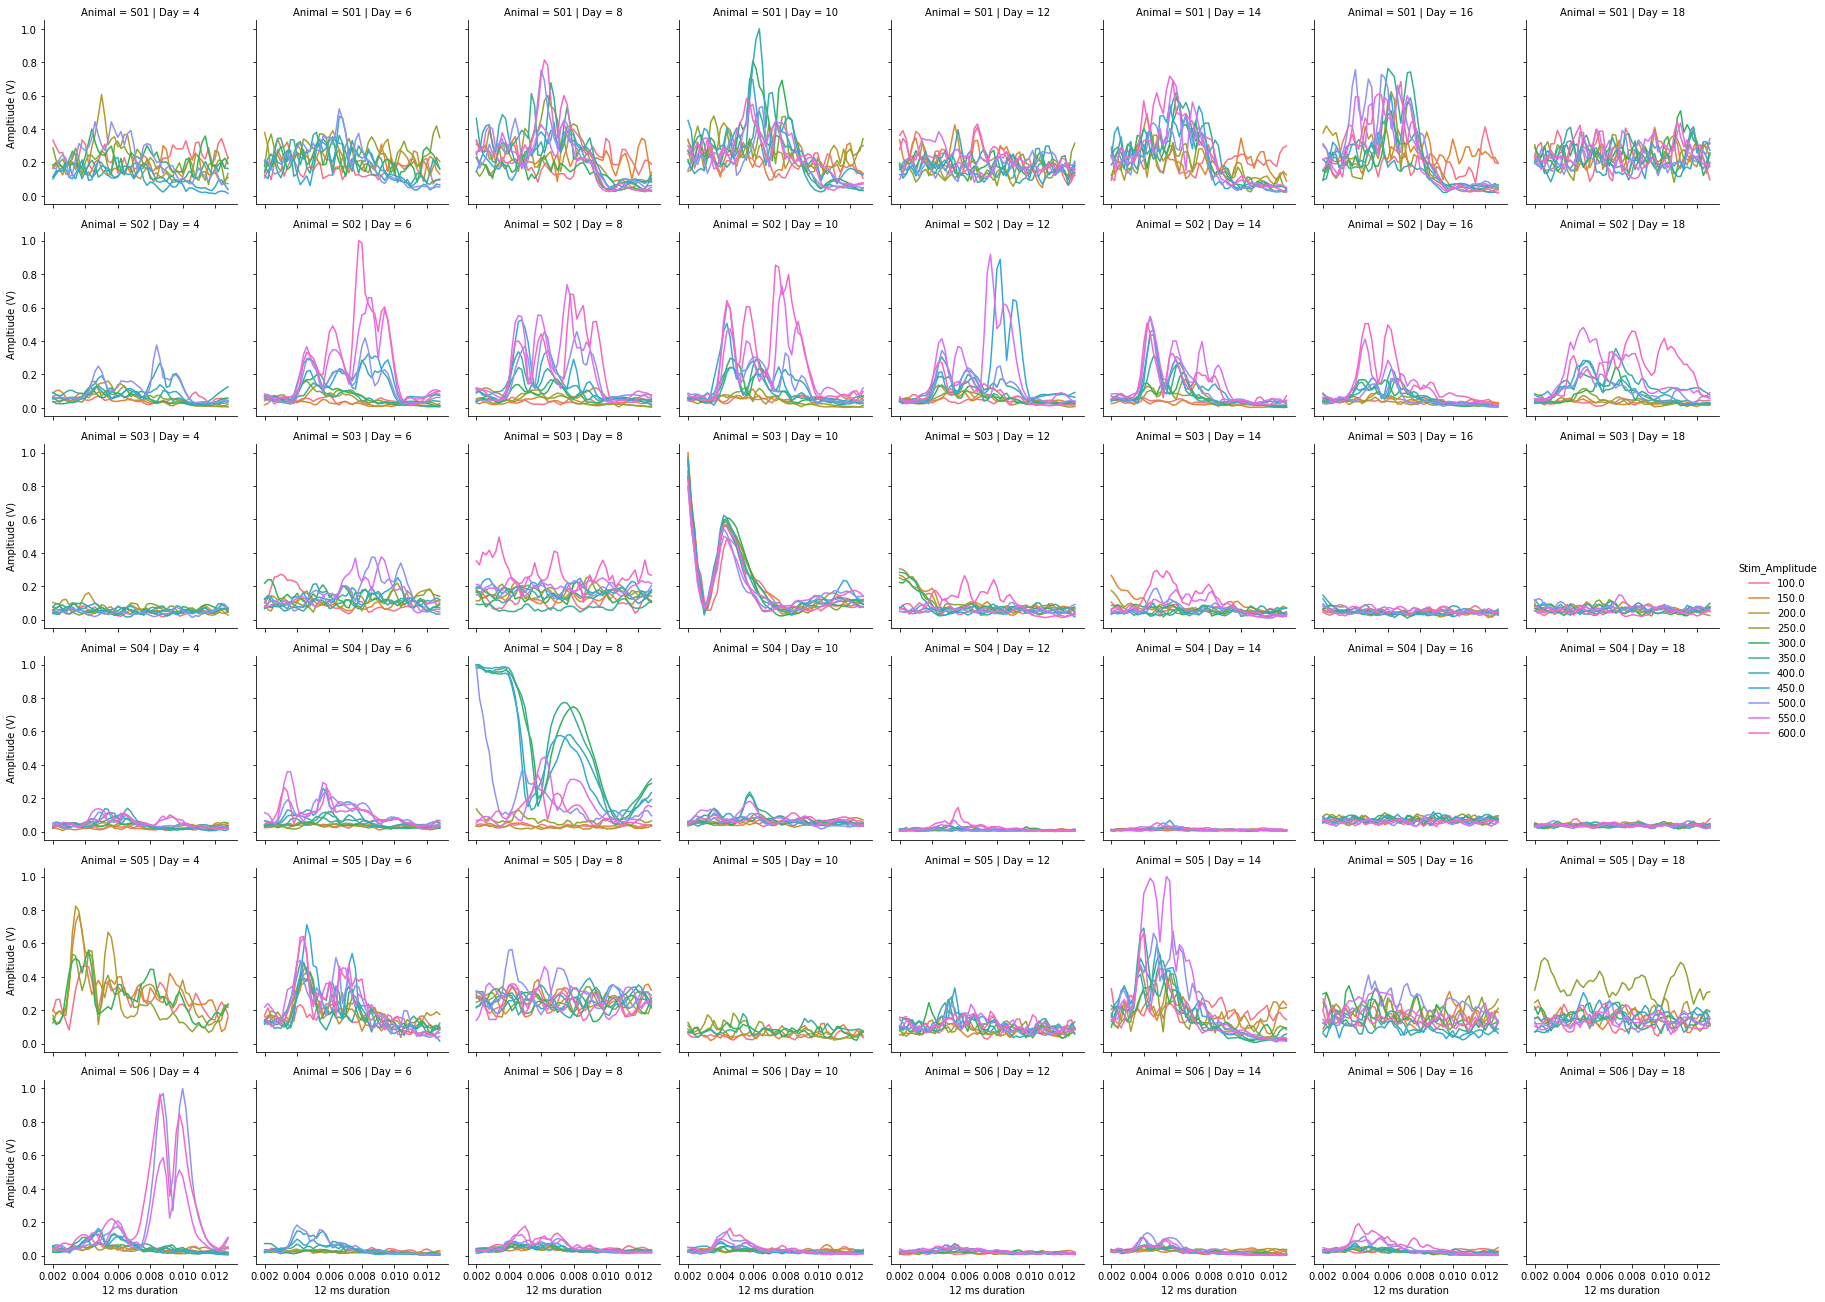

In [14]:
g = sns.FacetGrid(df_bin, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Time', y='STA_Scaled')
g.set_axis_labels('12 ms duration', 'Ampltiude (V)')
g.add_legend()

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [15]:
from scipy import integrate

df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
df_auc = df_auc.dropna()
df_auc.head()

,Animal,Day,Side,Stim_Amplitude,Bin,STA_AUC
0,S01,4,Left,100.0,1 to 4 ms,2.113402
1,S01,4,Left,100.0,4 to 7 ms,2.801460
2,S01,4,Left,100.0,7 to 10 ms,3.015846
3,S01,4,Left,100.0,10 to 13 ms,3.793153
5,S01,4,Left,150.0,1 to 4 ms,1.605589


In [16]:
df_auc.groupby(['Animal', 'Stim_Amplitude', 'Bin'])['STA_AUC']
# df_auc.head(20)

### Exploratory Data Analysis

We have our final data frame to use for this analysis, df_auc, and we can start our EDA.

<AxesSubplot:xlabel='Day', ylabel='Animal'>

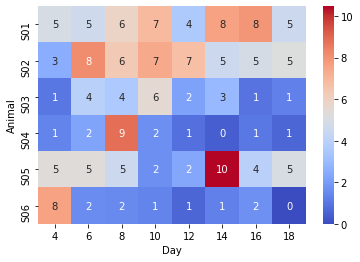

In [17]:
# Use a heatmap to look at animal (y), day (x), and max AUC (heat)

df_animal_day = df_auc.groupby(['Animal', 'Day'])['STA_AUC'].max().reset_index()
df_animal_day_pivot = df_animal_day.pivot(index='Animal', columns='Day', values='STA_AUC').fillna(0)
sns.heatmap(df_animal_day_pivot, annot=True, fmt='.0f', cmap="coolwarm")

###### Tons of plots

- Does the day have an influence on AUC?
- Does the time bine have an influence on AUC?
- Does the stim amplitude have an influence on AUC?

### Other analyses

- Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
- Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
- Time domains of stimulus triggered average
- Differences in any of these parameters based on time of day?
- How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
- Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
- Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.
- Add information on time of day and stimulus amplitude from Neurochip